**Algortimo Page Rank**

In [67]:
from collections import Counter
import tqdm
import networkx as nx
import matplotlib.pyplot as plt



# Usuarios y respaldos
users = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
endorsements = [
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), 
    (3, 4), (4, 5), (5, 6), (5, 7), 
    (6, 8), (7, 8), (8, 9)
]

from collections import Counter 
endorsements_counter = Counter(tarjet for source, tarjet in endorsements)

from typing import NamedTuple
class User(NamedTuple):
    id: int
    name: str
users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

friend_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3),
(3, 4), (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]


Amistades como diccionarios

In [69]:
from typing import Dict, List

# Define the type alias
FriendshipType = Dict[int, List[int]]

# Initialize the variable using the type alias
Friendships: FriendshipType = {user.id: [] for user in users}
for i, j in friend_pairs:
    Friendships[i].append(j)
    Friendships[j].append(i)

# Assertions to verify the correctness of the data
assert Friendships[4] == [3, 5]
assert Friendships[8] == [6, 7, 9]


Frist Search

In [72]:
from collections import deque
from typing import List, Dict

Path = List[int]

def shortest_paths_from(from_user_id: int, friendships: Dict[int, List[int]]) -> Dict[int, List[Path]]:
	# A dictionary from user_id to "all" shortest paths to that user.
	shortest_paths_to: Dict[int, List[Path]] = {from_user_id: [[]]}
	# A queue of (previous user, next user) that we need to check.
	# Starts out with all pairs (from_user, friend_of_from_user).
	frontier = deque((from_user_id, friend_id) for friend_id in friendships[from_user_id])
	# Keep going until we empty the queue.
	while frontier:
		# Remove the pair that's next in the queue.
		prev_user_id, user_id = frontier.popleft()
		# Because of the way we're adding to the queue,
		# necessarily we already know some shortest paths to prev_user.
		paths_to_prev_user = shortest_paths_to[prev_user_id]
		new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]
		# It's possible we already know a shortest path to user_id.
		old_paths_to_user = shortest_paths_to.get(user_id, [])
		# What's the shortest path to here that we've seen so far?
		if old_paths_to_user:
			min_path_length = len(old_paths_to_user[0])
		else:
			min_path_length = float("inf")
		# Only keep paths that aren't too long and are actually new.
		new_paths_to_user = [
			path
			for path in new_paths_to_user
			if len(path) <= min_path_length and path not in old_paths_to_user
		]
		shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user
		# Add never-seen neighbors to the frontier.
		frontier.extend(
			(user_id, friend_id)
			for friend_id in friendships[user_id]
			if friend_id not in shortest_paths_to
		)
	return shortest_paths_to


In [74]:
shortest_paths={user.id: shortest_paths_from(user.id, Friendships) for user in users}

Betweens

In [76]:
betweenness_centrality = {user.id: 0.0 for user in users}
for source in users:
	for target_id, paths in shortest_paths[source.id].items():
		if source.id < target_id:
			# don't double count
			num_paths = len(paths)
			# how many shortest paths?
			contrib = 1 / num_paths
			# contribution to centrality
			for path in paths:
				for between_id in path:
					if between_id not in [source.id, target_id]:
						betweenness_centrality[between_id] += contrib

Closeness Centrality 

In [78]:
def farness(user_id: int) -> float:
    """Farness centrality of a user."""
    # The sum of the lengths of the shortest paths to all other users.
    # We can use the shortest_paths dictionary to get this information.
    paths = shortest_paths[user_id]
    return sum(len(paths[0]) for paths in shortest_paths[user_id].values())

closeness_centrality = {user.id: 1 / farness(user.id) for user in users}

Eigenvector Centrality 

In [93]:
from typing import List, Callable

# Define Matrix and Vector types
Matrix = List[List[float]]
Vector = List[float]

def shape(matrix: Matrix) -> (int, int):
	"""Returns the number of rows and columns in a matrix."""
	num_rows = len(matrix)
	num_cols = len(matrix[0]) if matrix else 0
	return num_rows, num_cols

def make_matrix(num_rows: int, num_cols: int, entry_fn: Callable[[int, int], float]) -> Matrix:
	"""Creates a matrix with the given shape and entry function."""
	return [[entry_fn(i, j) for j in range(num_cols)] for i in range(num_rows)]

def dot(v: Vector, w: Vector) -> float:
	"""Computes the dot product of two vectors."""
	assert len(v) == len(w), "Vectors must be the same length"
	return sum(v_i * w_i for v_i, w_i in zip(v, w))

def matrix_times_matrix(m1: Matrix, m2: Matrix) -> Matrix:
	"""Multiplies two matrices."""
	nr1, nc1 = shape(m1)
	nr2, nc2 = shape(m2)
	assert nc1 == nr2, "must have (# of columns in m1) == (# of rows in m2)"
	
	def entry_fn(i: int, j: int) -> float:
		# Dot product of i-th row of m1 with j-th column of m2
		return sum(m1[i][k] * m2[k][j] for k in range(nc1))
	
	return make_matrix(nr1, nc2, entry_fn)

def matrix_times_vector(m: Matrix, v: Vector) -> Vector:
	"""Multiplies a matrix by a vector."""
	nr, nc = shape(m)
	n = len(v)
	assert nc == n, "must have (# of cols in m) == (# of elements in v)"
	return [dot(row, v) for row in m]  # output has length nr

Eigenvector

In [95]:
from typing import Tuple
import random
import math

def magnitude(v: Vector) -> float:
	"""Returns the magnitude (length) of a vector."""
	return math.sqrt(sum(x ** 2 for x in v))

def distance(v: Vector, w: Vector) -> float:
	"""Returns the distance between two vectors."""
	return math.sqrt(sum((vi - wi) ** 2 for vi, wi in zip(v, w)))

def find_eigenvector(m: Matrix, tolerance: float = 0.00001) -> Tuple[Vector, float]:
	guess = [random.random() for _ in m]
	while True:
		result = matrix_times_vector(m, guess)
		# transform guess
		norm = magnitude(result)
		# compute norm
		next_guess = [x / norm for x in result]
		# rescale
		if distance(guess, next_guess) < tolerance:
			# convergence so return (eigenvector, eigenvalue)
			return next_guess, norm
		guess = next_guess


Centralidad

In [98]:
def entry_fn(i: int, j: int):
	return 1 if (i, j) in friend_pairs or (j, i) in friend_pairs else 0

n = len(users)
adjacency_matrix = make_matrix(n, n, entry_fn)
eigenvector_centralities, _ = find_eigenvector(adjacency_matrix)

In [105]:
# Usuarios y respaldos
users = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
endorsements = [
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), 
    (3, 4), (4, 5), (5, 6), (5, 7), 
    (6, 8), (7, 8), (8, 9)
]

from collections import Counter 
endorsements_counter = Counter(tarjet for source, tarjet in endorsements)

In [114]:
import tqdm
from typing import List, Tuple, Dict
from collections import Counter

def page_rank(users: List[User],
			  endorsements: List[Tuple[int, int]],
			  damping: float = 0.85,
			  num_iters: int = 100) -> Dict[int, float]:
	# Compute how many people each person endorses
	outgoing_counts = Counter(target for source, target in endorsements)
	
	# Initially distribute PageRank evenly
	num_users = len(users)
	pr = {user.id: 1 / num_users for user in users}
	
	# Small fraction of PageRank that each node gets each iteration
	base_pr = (1 - damping) / num_users
	
	for _ in tqdm.trange(num_iters):
		next_pr = {user.id: base_pr for user in users}  # start with base_pr
		for source, target in endorsements:
			# Add damped fraction of source pr to target
			next_pr[target] += damping * pr[source] / outgoing_counts[source]
		pr = next_pr
	
	return pr


100%|██████████| 100/100 [00:00<?, ?it/s]


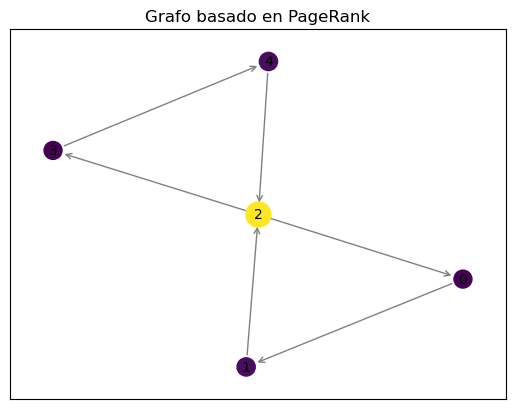

In [145]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo dirigido
def graficar_grafo(users, endorsements, damping=0.85, num_iters=100):
    # Ejecutar el algoritmo PageRank
    pr = page_rank(users, endorsements, damping, num_iters)

    # Crear el grafo utilizando NetworkX
    G = nx.DiGraph()
    G.add_edges_from(endorsements)
    
    # Añadir atributos de PageRank como etiquetas
    for node in G.nodes:
        G.nodes[node]['pagerank'] = pr[node]

    # Posiciones de los nodos
    pos = nx.spring_layout(G)  # Layout de resorte para mayor claridad

    # Dibujar nodos con tamaños escalados por PageRank
    node_sizes = [1000 * pr[node] for node in G.nodes]  # Escalar tamaños
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.viridis, node_color=list(pr.values()))
    
    # Dibujar las aristas
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color="gray")

    # Añadir etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # Mostrar el grafo
    plt.title("Grafo basado en PageRank")
    plt.show()

# Ejemplo de uso
class User:
    def __init__(self, id):
        self.id = id

# Crear usuarios y relaciones de ejemplo
users = [User(i) for i in range(5)]
endorsements = [(0, 1), (1, 2), (2, 0), (2, 3), (3, 4), (4, 2)]

graficar_grafo(users, endorsements)


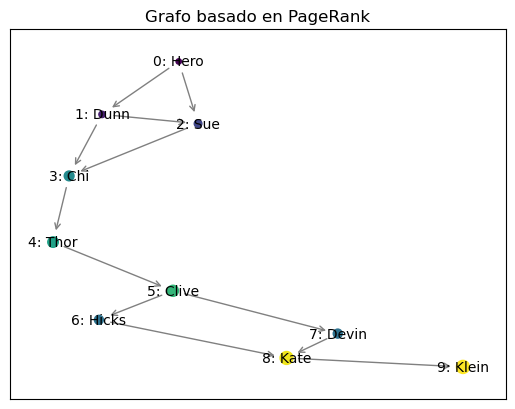

: 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import NamedTuple

# Definición de la clase User
class User(NamedTuple):
    id: int
    name: str

# Implementación básica de PageRank (simplificada)
def page_rank(users, endorsements, damping=0.85, num_iters=100):
    # Crear un diccionario de PageRank inicial
    pr = {user.id: 1.0 / len(users) for user in users}
    
    # Crear un diccionario de enlaces salientes
    out_links = {user.id: [] for user in users}
    for source, target in endorsements:
        out_links[source].append(target)
    
    # Iterar para actualizar PageRank
    for _ in range(num_iters):
        new_pr = {}
        for user in users:
            # Suma de contribuciones de páginas que enlazan a esta
            incoming = 0.0
            for source, target in endorsements:
                if target == user.id:
                    incoming += pr[source] / len(out_links[source])
            
            # Actualizar PageRank
            new_pr[user.id] = (1 - damping) / len(users) + damping * incoming
        
        pr = new_pr
    
    return pr

# Crear el grafo dirigido
def graficar_grafo(users, endorsements, damping=0.85, num_iters=100):
    # Ejecutar el algoritmo PageRank
    pr = page_rank(users, endorsements, damping, num_iters)

    # Crear el grafo utilizando NetworkX
    G = nx.DiGraph()
    G.add_edges_from(endorsements)
    
    # Añadir atributos de PageRank como etiquetas
    for node in G.nodes:
        G.nodes[node]['pagerank'] = pr[node]

    # Posiciones de los nodos
    pos = nx.spring_layout(G)  # Layout de resorte para mayor claridad

    # Dibujar nodos con tamaños escalados por PageRank
    node_sizes = [1000 * pr[node] for node in G.nodes]  # Escalar tamaños
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.viridis, node_color=list(pr.values()))
    
    # Dibujar las aristas
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color="gray")

    # Añadir etiquetas de nodos
    labels = {user.id: f"{user.id}: {user.name}" for user in users}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="black")

    # Mostrar el grafo
    plt.title("Grafo basado en PageRank")
    plt.show()

# Datos de ejemplo
users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
         User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
         User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

endorsements = [
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), 
    (3, 4), (4, 5), (5, 6), (5, 7), 
    (6, 8), (7, 8), (8, 9)
]

graficar_grafo(users, endorsements)

Page Rank Ajustado Nodo 4

100%|██████████| 100/100 [00:00<?, ?it/s]

El usuario 5 tiene el mayor PageRank con un valor de: 0.17121533665903185


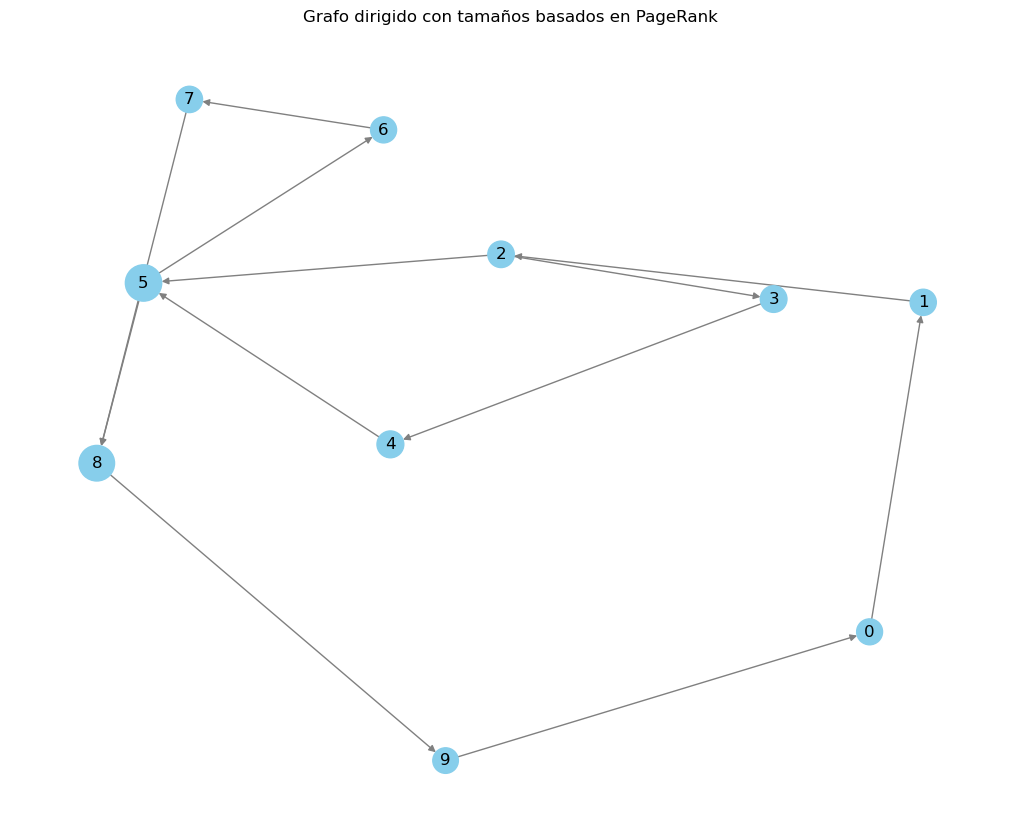

In [91]:
# Calculamos el PageRank
pr = page_rank(users, endorsements)

# Encontrar el usuario con el mayor PageRank
max_pr_user = max(pr, key=pr.get)

# Verificar si el usuario 4 tiene el mayor PageRank
if max_pr_user == 4:
    print("El usuario 4 tiene el mayor PageRank:", pr[4])
else:
    print(f"El usuario {max_pr_user} tiene el mayor PageRank con un valor de: {pr[max_pr_user]}")

# Crear el grafo dirigido
G = nx.DiGraph()
G.add_edges_from(endorsements)

# Dibujar el grafo con tamaños dinámicos
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Posicionamiento de nodos

# Escalar el tamaño de los nodos según el PageRank
node_sizes = [4000 * pr[node] for node in G.nodes()]  # Ajusta el factor de escala

# Dibujar el grafo
nx.draw(
    G, pos, with_labels=True, node_color='skyblue', edge_color='gray',
    node_size=node_sizes, font_size=12, arrows=True
)

# Mostrar los valores de PageRank en los nodos
labels = {node: f'{pr[node]:.2f}' for node in G.nodes()}
#nx.draw_networkx_labels(G, pos, labels=labels, font_color='black')

plt.title("Grafo dirigido con tamaños basados en PageRank")
plt.show()

Camino más corto de 1 a 1: [1]
Camino más corto de 1 a 2: [1, 2]
Camino más corto de 1 a 3: [1, 3]
Camino más corto de 1 a 4: [1, 3, 4]
Camino más corto de 1 a 5: [1, 3, 4, 5]
Camino más corto de 1 a 6: [1, 3, 4, 5, 6]
Camino más corto de 1 a 7: [1, 3, 4, 5, 7]
Camino más corto de 1 a 8: [1, 3, 4, 5, 6, 8]
Camino más corto de 1 a 9: [1, 3, 4, 5, 6, 8, 9]


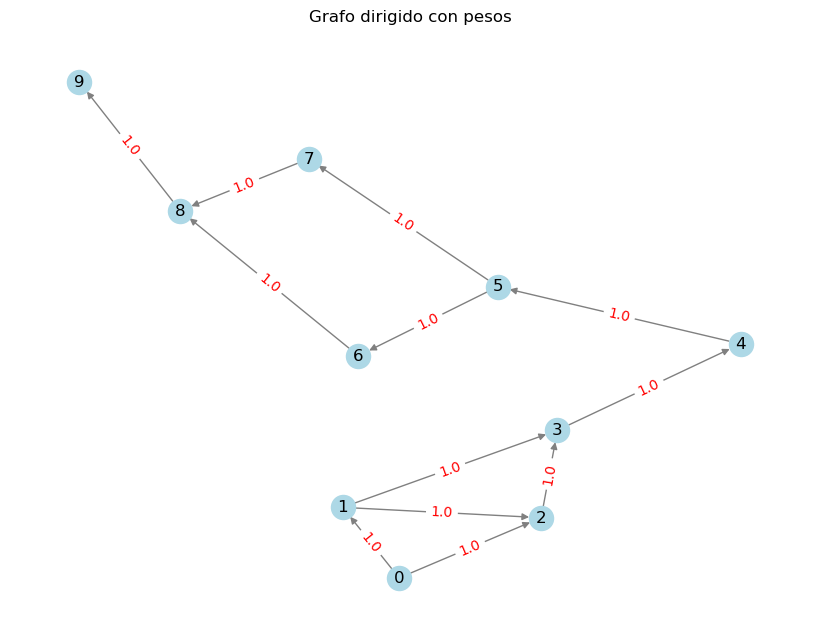

In [86]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo dirigido con pesos
G = nx.DiGraph()
G.add_weighted_edges_from([
    (0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0),
    (3, 4, 1.0), (4, 5, 1.0), (5, 6, 1.0), (5, 7, 1.0), (6, 8, 1.0), (7, 8, 1.0), (8, 9, 1.0)
])

# Encontrar el camino más corto desde el nodo 1 a todos los demás
source_node = 1
shortest_paths = nx.single_source_dijkstra_path(G, source=source_node)

# Mostrar los resultados
for target, path in shortest_paths.items():
    print(f"Camino más corto de {source_node} a {target}: {path}")

# Dibujar el grafo
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=12)
edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.title("Grafo dirigido con pesos")
plt.show()

Carga Archivo

In [3]:
#Importaciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ruta_smartphone = r"smartphones.csv"  # Corrected file name
df_smartphone = pd.read_csv(ruta_smartphone)
df_smartphone.head(10)



,brand_name,model,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,...,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,Apple iPhone 11,38999,7.3,0,bionic,6.0,2.65,3110.0,0,...,64,6.1,60,2,ios,12.0,12.0,0,1792,828
1,apple,Apple iPhone 11 (128GB),46999,7.5,0,bionic,6.0,2.65,3110.0,0,...,128,6.1,60,2,ios,12.0,12.0,0,1792,828
2,apple,Apple iPhone 11 Pro Max,109900,7.7,0,bionic,6.0,2.65,3500.0,1,...,64,6.5,60,3,ios,12.0,12.0,0,2688,1242
3,apple,Apple iPhone 12,51999,7.4,1,bionic,6.0,3.10,NaN,0,...,64,6.1,60,2,ios,12.0,12.0,0,2532,1170
4,apple,Apple iPhone 12 (128GB),55999,7.5,1,bionic,6.0,3.10,NaN,0,...,128,6.1,60,2,ios,12.0,12.0,0,2532,1170
5,apple,Apple iPhone 12 (256GB),67999,7.6,1,bionic,6.0,3.10,NaN,0,...,256,6.1,60,2,ios,12.0,12.0,0,2532,1170
6,apple,Apple iPhone 12 Mini,40999,7.4,1,bionic,6.0,3.10,NaN,0,...,64,5.4,60,2,ios,12.0,12.0,0,2340,1080
7,apple,Apple iPhone 12 Mini (128GB),45999,7.5,1,bionic,6.0,3.10,NaN,0,...,128,5.4,60,2,ios,12.0,12.0,0,2340,1080
8,apple,Apple iPhone 12 Mini (256GB),55999,7.5,1,bionic,6.0,3.10,NaN,0,...,256,5.4,60,2,ios,12.0,12.0,0,2340,1080
9,apple,Apple iPhone 12 Pro (256GB),119900,8.0,1,bionic,6.0,3.10,NaN,0,...,256,6.1,60,3,ios,12.0,12.0,0,2532,1170


Algortimo Page Rank

In [6]:
import networkx as nx

# Crear un grafo vacío
G_brand = nx.DiGraph()

# Agregar nodos al grafo (cada marca será un nodo)
brands = df_smartphone['brand_name'].unique()
for brand in brands:
    G_brand.add_node(brand)

# Agregar aristas basadas en similitud (ejemplo: marcas que comparten modelos similares)
for i, row_i in df_smartphone.iterrows():
    for j, row_j in df_smartphone.iterrows():
        if i != j and row_i['brand_name'] != row_j['brand_name']:
            G_brand.add_edge(row_i['brand_name'], row_j['brand_name'])

# Calcular el PageRank
pagerank_brand_scores = nx.pagerank(G_brand)

# Convertir los resultados a un DataFrame para facilitar su análisis
pagerank_brand_df = pd.DataFrame(list(pagerank_brand_scores.items()), columns=['brand_name', 'pagerank_score'])
pagerank_brand_df = pagerank_brand_df.sort_values(by='pagerank_score', ascending=False)

# Mostrar las 10 marcas con mayor puntaje de PageRank
print(pagerank_brand_df.head(5))


   brand_name  pagerank_score
0       apple        0.021739
34      redmi        0.021739
25   motorola        0.021739
26      nokia        0.021739
27    nothing        0.021739


Algortimo Djkstra